ALEXNET

In [ ]:
import os
import keras
import cv2
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import time
from google.colab import drive
drive.mount('/content/drive')
import numpy as np

assert tf.__version__.startswith('2')
!sudo apt-get install libportaudio2
!pip install opencv-contrib-python

from PIL import Image
from keras import backend as K
from keras.models import load_model
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


Mounted at /content/drive
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 12 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 0s (160 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling b

In [ ]:
train_path="/content/drive/My Drive/Colab Notebooks/data/gaf_images"
train_path = os.path.join(os.path.dirname(train_path),'train')
test_path="/content/drive/My Drive/Colab Notebooks/data/gaf_images"
test_path = os.path.join(os.path.dirname(test_path), 'test')
val_path="/content/drive/My Drive/Colab Notebooks/data/gaf_images"
val_path = os.path.join(os.path.dirname(val_path),'val')


In [ ]:
# !pip install split-folders
# import splitfolders
# input_folder = '/content/drive/My Drive/Colab Notebooks/data/gaf_images'

# # Split with a ratio.
# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
# #Train, val, test
# splitfolders.ratio(input_folder, output='/content/drive/My Drive/Colab Notebooks/data', 
#                    seed=42, ratio=(.7, .2, .1), 
#                    group_prefix=None) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 1664 files [00:46, 36.08 files/s]


In [ ]:
# Load training, test and validation data
batch_size = 32
img_height = 227
img_width = 227
IMG_SHAPE =227
train_ds = tf.keras.preprocessing.image_dataset_from_directory( train_path, image_size=(img_height, img_width), batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory( val_path, image_size=(img_height, img_width), batch_size=batch_size)
test_ds = tf.keras.preprocessing.image_dataset_from_directory( test_path, image_size=(img_height, img_width), batch_size=batch_size)

Found 1163 files belonging to 4 classes.
Found 331 files belonging to 4 classes.
Found 170 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3']


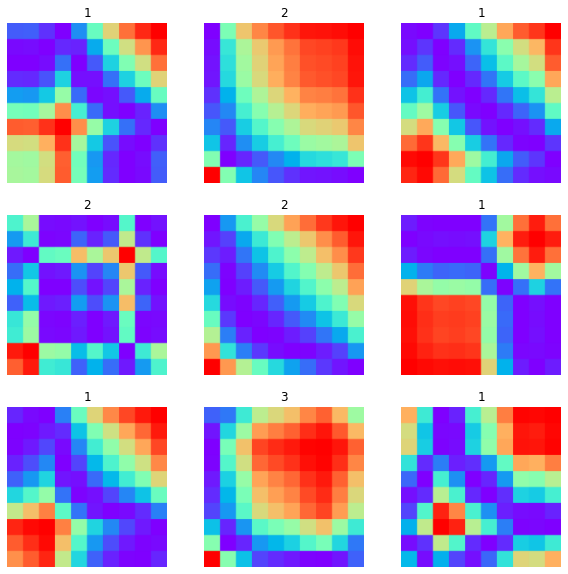

In [ ]:
#Visualize the data

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#Standardize
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 227x227
    image = tf.image.resize(image, (227,227))
    return image, label

In [ ]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
val_ds_size = tf.data.experimental.cardinality(val_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", val_ds_size)

Training data size: 37
Test data size: 6
Validation data size: 11


In [ ]:
train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  )
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  )
val_ds = (val_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                 )

In [ ]:
#Create a model
model = keras.models.Sequential([
          keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
          keras.layers.BatchNormalization(),
          keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
          keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
          keras.layers.BatchNormalization(),
          keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
          keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
          keras.layers.BatchNormalization(),
          keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
          keras.layers.BatchNormalization(),
          keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
          keras.layers.BatchNormalization(),
          keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
          keras.layers.Flatten(),
          keras.layers.Dense(4096, activation='relu'),
          keras.layers.Dropout(0.5),
          keras.layers.Dense(4096, activation='relu'),
          keras.layers.Dropout(0.5),
          keras.layers.Dense(4, activation='softmax')
        
      ])

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt ,loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
hist_dfall=[]
for i in range(0,10):
      history=model.fit(train_ds,
                epochs=3,
                validation_data=val_ds,
                callbacks=[early_stop],
                batch_size=batch_size
                )
      hist_df = pd.DataFrame(history.history)
      hist_dfall=pd.DataFrame(hist_dfall).append(hist_df)
      hist_csv_file = '/content/drive/My Drive/Colab Notebooks/history3.csv'
      with open(hist_csv_file, mode='w') as f:
            hist_dfall.to_csv(f)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


37/37 [==============================] - 10s 131ms/step - loss: 3.5555 - accuracy: 0.4127 - val_loss: 1.4434 - val_accuracy: 0.2508
Epoch 2/3
37/37 [==============================] - 6s 113ms/step - loss: 2.0394 - accuracy: 0.4979 - val_loss: 1.4681 - val_accuracy: 0.3082
Epoch 3/3
37/37 [==============================] - 5s 75ms/step - loss: 1.6774 - accuracy: 0.5408 - val_loss: 1.5820 - val_accuracy: 0.3051
Epoch 1/3
37/37 [==============================] - 6s 110ms/step - loss: 1.5413 - accuracy: 0.5477 - val_loss: 1.7256 - val_accuracy: 0.3776
Epoch 2/3
37/37 [==============================] - 6s 100ms/step - loss: 1.3280 - accuracy: 0.5658 - val_loss: 1.3301 - val_accuracy: 0.4441
Epoch 3/3
37/37 [==============================] - 5s 81ms/step - loss: 1.2198 - accuracy: 0.6036 - val_loss: 2.7829 - val_accuracy: 0.3142
Epoch 1/3
37/37 [==============================] - 5s 78ms/step - loss: 1.0694 - accuracy: 0.6380 - val_loss: 1.5225 - val_accuracy: 0.4320
Epoch 2/3
37/37 [========

In [ ]:
result = model.evaluate(test_ds,batch_size=batch_size)
print("test_loss, test accuracy",result)

6/6 [==============================] - 1s 97ms/step - loss: 0.8140 - accuracy: 0.7176
test_loss, test accuracy [0.8139790296554565, 0.7176470756530762]


GasNet example

In [ ]:
import os
import cv2
from PIL import Image
import pandas as pd
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
data= pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset_Etylene_CO.csv')
x_train= data.iloc[:,4:20].to_numpy()
y_train=data.iloc[:,3]

In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))


In [ ]:
#Import Module
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, 
                                                    train_size=0.7,
                                                    test_size=0.3,
                                                    random_state=122)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((734002, 16, 1), (734002,), (314573, 16, 1), (314573,))

In [ ]:
num_classes = len(np.unique(Y_train))

In [ ]:
input_shape=X_train.shape[0:]
input_shape

(734002, 16, 1)

In [ ]:
from keras.layers.normalization.batch_normalization import BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.python.keras import regularizers
model = Sequential()
model.add(Conv2D(input_shape=(16,734002,1),filters=32,kernel_size=(3,3),padding="same"))
model.add(BatchNormalization())
model.add(layers.Activation(activations.relu))
model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same"))
model.add(BatchNormalization())
model.add(layers.Activation(activations.relu))
model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same"))
model.add(BatchNormalization())
model.add(layers.Activation(activations.relu))
model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same"))
model.add(BatchNormalization())
model.add(layers.Activation(activations.relu))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), padding='same' ))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same"))
model.add(BatchNormalization())
model.add(layers.Activation(activations.relu))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same"))
model.add(BatchNormalization())
model.add(layers.Activation(activations.relu))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same"))
model.add(BatchNormalization())
model.add(layers.Activation(activations.relu))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same"))
model.add(BatchNormalization())
model.add(layers.Activation(activations.relu))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), padding='same' ))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding="same"))
model.add(BatchNormalization())
model.add(layers.Activation(activations.relu))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding="same"))
model.add(BatchNormalization())
model.add(layers.Activation(activations.relu))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding="same"))
model.add(BatchNormalization())
model.add(layers.Activation(activations.relu))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding="same"))
model.add(BatchNormalization())
model.add(layers.Activation(activations.relu))
model.add(keras.layers.GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))


In [ ]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.0001
)
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 734002, 32)    320       
                                                                 
 batch_normalization (BatchN  (None, 16, 734002, 32)   128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 16, 734002, 32)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 734002, 32)    9248      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 734002, 32)   128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 16, 734002, 32)    0

In [ ]:
batch_size = 32
#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)



gasnet_classifier = model.fit(X_train,Y_train,validation_split=0.1,
    verbose=1,
epochs = 20,
callbacks=[early_stop],
batch_size=batch_size)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


20644/20644 [==============================] - ETA: 0s - loss: 0.2824 - accuracy: 0.8856

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


20644/20644 [==============================] - 219s 10ms/step - loss: 0.2824 - accuracy: 0.8856 - val_loss: 0.1860 - val_accuracy: 0.9158
Epoch 2/20
20644/20644 [==============================] - 212s 10ms/step - loss: 0.1810 - accuracy: 0.9226 - val_loss: 0.1627 - val_accuracy: 0.9348
Epoch 3/20
20644/20644 [==============================] - 198s 10ms/step - loss: 0.1494 - accuracy: 0.9361 - val_loss: 0.1293 - val_accuracy: 0.9404
Epoch 4/20
20644/20644 [==============================] - 197s 10ms/step - loss: 0.1318 - accuracy: 0.9437 - val_loss: 0.1230 - val_accuracy: 0.9460
Epoch 5/20
20644/20644 [==============================] - 201s 10ms/step - loss: 0.1201 - accuracy: 0.9486 - val_loss: 0.1275 - val_accuracy: 0.9452
Epoch 6/20
20644/20644 [==============================] - 201s 10ms/step - loss: 0.1115 - accuracy: 0.9524 - val_loss: 0.1379 - val_accuracy: 0.9457
Epoch 7/20
20644/20644 [==============================] - 196s 10ms/step - loss: 0.1051 - accuracy: 0.9556 - val_loss

In [ ]:
result = model.evaluate(X_test,Y_test, verbose=0)
print("test_loss, test accuracy",result)

test_loss, test accuracy [0.07738962024450302, 0.9655660390853882]
